In [9]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import joblib
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from sklearn.decomposition import PCA


In [10]:
def resize_all(src, pklname, include, width=150, height=None, multi=True):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})pneumonie images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-4:] == 'jpeg':
                    im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)

                    # Redimensionner l'image à la taille cible
                    im = cv2.resize(im, (width, height))

                    # Normaliser les valeurs de pixel pour les ramener à une échelle commune (0 à 1)
                    im = im / 255.0
                    label = subdir
                    if subdir == "PNEUMONIA" and multi:
                        label = file[:-4].split('_')[1].upper()
                    data['label'].append(label)
                    data['filename'].append(file)
                    data['data'].append(im)
        joblib.dump(data, pklname)
    return data

In [11]:
img_path = "/home/hamdi/delivery/zoidberg/chest_Xray/"
subdirs = set(["NORMAL", "PNEUMONIA"])

In [12]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [13]:
data_train = resize_all(img_path + "train", "pneumonia", subdirs, multi=True)
data_test = resize_all(img_path + "test", "pneumonia", subdirs, multi=True)

NORMAL
PNEUMONIA
NORMAL
PNEUMONIA


In [14]:

#Concatenate img from train and test to prepare for split
data_img = np.concatenate((data_train['data'], data_test['data']), axis=0)
data_labels = np.concatenate((data_train['label'], data_test['label']), axis=0)

X, y = data_img, data_labels
print(X.shape)


(5840, 150, 150)


In [15]:
# create an instance of each transformer
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)

scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X = [img.flatten() for img in X]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data_labels)
#print(X_train.shape)
X_train = scalify.fit_transform(X_train)
X_test = scalify.transform(X_test)

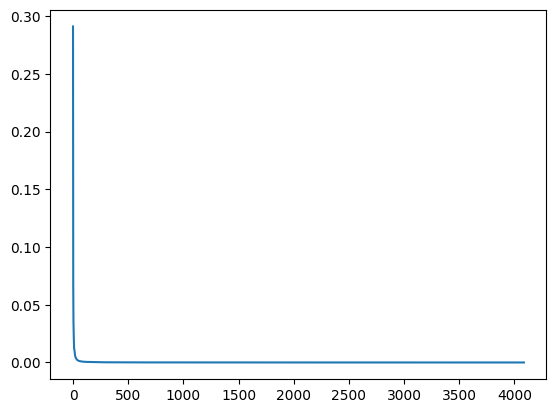

In [16]:
pca = PCA()
pca_values = pca.fit_transform(X_train)

variance = pca.explained_variance_ratio_
plt.plot(variance)

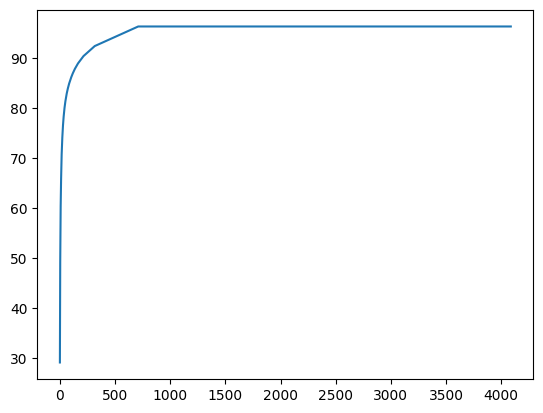

In [17]:
cum_variance = np.cumsum(np.round(variance, 4) * 100)
plt.plot(cum_variance)

# Find the best component number for PCA
nb_components = 1
count = 1
for i in cum_variance:
    if i >= 98:
        nb_components = count
        break
    count += 1

In [18]:
best_pca = PCA(n_components=0.98)
X_train = best_pca.fit_transform(X_train)
X_test = best_pca.transform(X_test)

In [19]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [20]:
#X_test_hog = hogify.transform(X_test)
#X_test_prepared = scalify.transform(X_test)

In [21]:
y_pred = sgd_clf.predict(X_test)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))


[ True  True  True  True  True  True False  True  True  True  True  True
  True  True False  True False  True  True  True  True  True  True False
  True]

Percentage correct:  71.51826484018265


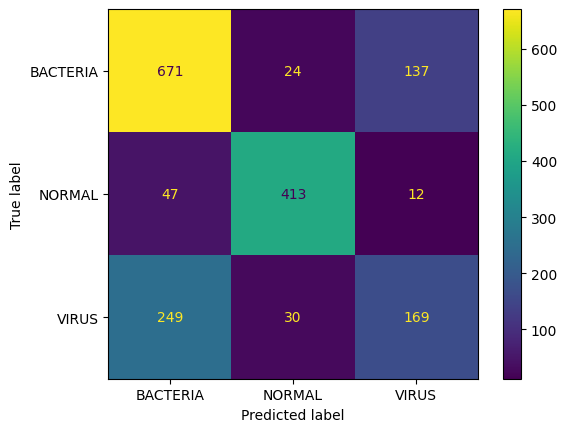

In [22]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [23]:
target_names = np.unique(data_labels)
report = metrics.classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    BACTERIA       0.69      0.81      0.75       832
      NORMAL       0.88      0.88      0.88       472
       VIRUS       0.53      0.38      0.44       448

    accuracy                           0.72      1752
   macro avg       0.70      0.69      0.69      1752
weighted avg       0.70      0.72      0.70      1752



In [26]:
#param_grid = { 'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#              'penalty': ['l2', 'l1', 'elasticnet', None],
#              'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
#              'l1_ratio': [0.0, 0.15, 0.4, 0.7, 0.9, 1.0],
#              'fit_intercept': [True, False],
#              'tol': [0.0, 1.0, 15.0, 150.0, 200.0, 1000.0],
#              'epsilon': [0.0, 0.1, 0.4, 0.5, 0.75, 0.9, 1.0, 15.0, 100.0],
#              'random_state': [42],
#              'eta0': [0.0, 0.1, 0.4, 0.5, 0.75, 0.9, 1.0, 15.0, 100.0],
#              'power_t': [0.0, 0.1, 0.4, 1.0, 15.0, 100.0, -5.0, -0.1, -0.5, -15.0]}


#best_param = {'alpha': 1, 'loss': 'log_loss', 'penalty': 'l2'} => 76.9977 %
param_grid = {
    'loss': ['modified_huber', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
}
grid = GridSearchCV(SGDClassifier(), param_grid, refit = True, verbose = 0, n_jobs=3) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(metrics.classification_report(y_test, grid_predictions)) 

/home/hamdi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hamdi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hamdi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hamdi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/hamdi/.local/lib/python3.10/site-p

{'alpha': 1, 'loss': 'huber', 'penalty': 'l2'}
              precision    recall  f1-score   support

    BACTERIA       0.81      0.77      0.79       832
      NORMAL       0.88      0.88      0.88       472
       VIRUS       0.58      0.63      0.61       448

    accuracy                           0.77      1752
   macro avg       0.76      0.76      0.76      1752
weighted avg       0.77      0.77      0.77      1752



Percentage correct:  76.99771689497717
              precision    recall  f1-score   support

    BACTERIA       0.76      0.87      0.81       832
      NORMAL       0.82      0.93      0.87       472
       VIRUS       0.69      0.42      0.52       448

    accuracy                           0.77      1752
   macro avg       0.76      0.74      0.74      1752
weighted avg       0.76      0.77      0.75      1752



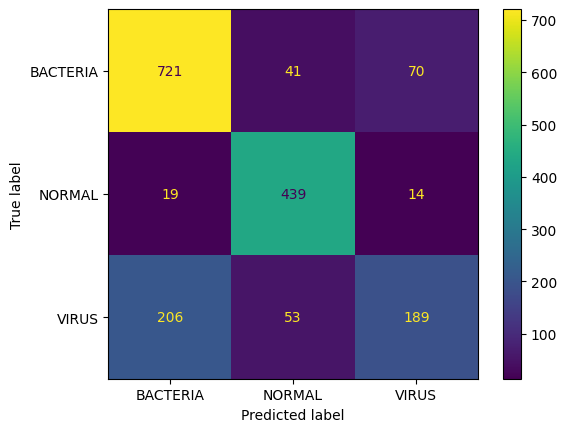

In [25]:
print('Percentage correct: ', 100*np.sum(grid_predictions == y_test)/len(y_test))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)


report = metrics.classification_report(y_true=y_test, y_pred=grid_predictions, target_names=target_names)
print(report)
